In [1]:
# Data preparation 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
from collections import Counter
%matplotlib inline

# Preprocessing and other libraries for modelling 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from joblib import dump, load
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

# Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

# Modelling - neural network
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout 
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
# from tensorflow.keras import Model, Sequential
# from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import MeanSquaredLogarithmicError

# Metrics 
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve, precision_recall_fscore_support

# Model interpretation 
import eli5
from eli5.sklearn import PermutationImportance
import shap

# 1. Goal
* Build a model that can predict healthcare providers who commit healthcare fraud.
* Healthcare fraud is a type of crime that involves the filing of dishonest health care claims in order to turn a profit. billing for services that weren't provided, performing unnecessary tests, and receiving benefits when patients are not eligible.

# 2. Dataset
* PartD_Prescriber_PUF_NPI_18.txt: list of healthcare providers who prescribed a drug covered by Medicare in 2018 (https://www.cms.gov/research-statistics-data-systems/medicare-provider-utilization-and-payment-data/medicare-provider-utilization-and-payment-data-part-d-prescriber/part-d-prescriber-data-cy-2018)
* UPDATED.csv: list of healthcare providers who were excluded due to healthcare fraud and other crimes (https://oig.hhs.gov/exclusions/exclusions_list.asp#instruct)
* I classified excluded providers in the 'UPDATED.csv' list as 'fraudulent providers.' For each provider in the 'PartD' set, I added the information in the 'UPDATED.csv' to see whether each provider commit fraud or not. I joined the two dataset using NPI (unique code for each provider).  

In [2]:
df = pd.read_csv('C:\\DS\\ML\\PartD_Prescriber_PUF_NPI_18.txt', delimiter = "\t") # data for each doc 
label = pd.read_csv('C:\\DS\\ML\\UPDATED.csv', dtype={'LASTNAME': 'str', 'FIRSTNAME': 'str', 'MIDNAME': 'str', 'BUSNAME':'str', 'GENERAL':'str', 'SPECIALTY': 'str', 'UPIN':'str','NPI':'int', 'DOB':'str','ADDRESS':'str','CITY':'str','STATE':'str', 'ZIP':'str','EXCLTYPE':'str','EXCLDATE':'str','REINDATE':'str','WAIVERDATE':'str','WVRSTATE':'str'})

In [3]:
df.shape # 1204935 entries, 84 columns

(1204935, 84)

In [4]:
label.shape # 74528 entries, 18 columns 

(74528, 18)

In [5]:
# merge - by npi (unique code for each provider)
df = df.merge(label, left_on='npi', right_on='NPI', how='left')

* Identifying the number and percentage of excluded health care providers: the column 'EXCLTYPE' shows why the provider was excluded.  
    - Explanation for exclusion codes: https://oig.hhs.gov/exclusions/authorities.asp
    - Exclusion codes directly related to Fraud: 1128a3, 1128b1, 1128b7
    - Other codes with a high frequency
        - 1128a4: Felony conviction relating to controlled substance. 
        - 1128a1: Conviction of program-related crimes. 
        - 1128b4: License revocation, suspension, or surrender. 
        - 1128a2: Conviction relating to patient abuse or neglect. Minimum Period: 5 years
* Summary: Most providers are normal and not excluded. 0.004% of the providers (47) committed (narrowly defined) fraud. 448 providers (0.037%) committed (broadly defined) fraud.  

In [6]:
# Identifying the number and percentage of excluded health care providers 
df['EXCLTYPE'] = df['EXCLTYPE'].str.strip()
df['exclude'] = df['EXCLTYPE'].apply(lambda x: 1 if x == x else 0)
df['fraud'] = df['EXCLTYPE'].apply(lambda x: 1 if x in ['1128a3','1128b1','1128b7'] else 0)

# Number of excluded / normal providers
print('Number of normal providers: {0}, {1:.5f}, Number of fraudulent providers: {2}, {3:.5f}'.format((df[df['fraud'] == 0].shape[0]),(df[df['fraud'] == 0].shape[0]/len(df)),df['fraud'].sum(),(df['fraud'].sum()/len(df))))
print('Number of normal providers: {0}, {1:.5f}, Number of excluded providers: {2}, {3:.5f}'.format((df['EXCLTYPE'].isnull().sum()),(df['EXCLTYPE'].isnull().sum()/len(df)),df['EXCLTYPE'].notna().sum(),(df['EXCLTYPE'].notna().sum()/len(df))))

Number of normal providers: 1204890, 0.99996, Number of fraudulent providers: 47, 0.00004
Number of normal providers: 1204489, 0.99963, Number of excluded providers: 448, 0.00037


## 2.1 Feature Selection
* Column description: https://www.cms.gov/files/document/part-d-prescriber-puf-methodology.pdf
* Columns dropped: address (too many categories), information about beneficiaries, number of beneficiaries, drug count, and drug cost for each beneficiary / drug category (difficult to process missing values) 

In [8]:
# The original credential column includes 10K+ categories - I grouped them into seven categories
def credential(row):
    doc = ['M,D.','M,D,','DENTIST','M.B.B.S','M D','M.B.B.S.','D. O.','M.D.','D.O,','MD', 'D.O.', 'DO', 'D.O','D.O.,', 'DDS', 'D.D.S.', 'MBBS', 'BMBS', 'MBChB', 'MBBCh','M.D','M. D.','D.D.S','MBCHB','MBBCH']
    ns = ['NURSE PRACTIONER','CNS','APN','N.P','A.P.N.','R.N','N.P.','A.P.N.P.', 'A.P.R.N.','C.N.M.','C.N.P.','C.R.N.A.','D.N.P.','L.P.N.','RN','NP','APNP','APRN','CNM','CNP','CRNA','DNP','LPN', 'NURSE PRACTITIONER']
    pa = ['P.A.','PA','P.A.-C.','PA-C','Physician assistant', 'PHYSICIAN ASSISTANT', 'P.A']
    od = ['O.D.','OD', 'O.D', 'OPTOMETRIST']
    dpm = ['DPM', 'D.P.M.', 'D.P.M']
    pharm = ['RPH', 'PHARM D', 'R.PH.','PHARMACIST', 'PHARM. D']
    row = row.replace('. ', '.')
    row = row.replace('  ', ' ')
    row = row.replace('.','')
    if any(word in row for word in doc):
        return 'Doctor'
    elif any(word in row for word in ns):
        return 'Nurse'
    elif any(word in row for word in pa):
        return 'Physician assistant'
    elif any(word in row for word in od):
        return 'Doctor of optometry' # related to eye
    elif any(word in row for word in dpm):
        return 'Doctor of podiatric medicine' # related to foot
    elif any(word in row for word in pharm):
        return 'Pharmacist'
    else:
        return 'Other'
df['credential'] = df['nppes_credentials'].apply(lambda row: credential(str(row)))

In [107]:
# Drop unnecessary columns 
cat_to_keep = ['nppes_provider_gender','credential','medicare_prvdr_enroll_status']
num_to_keep = ['total_claim_count','total_30_day_fill_count','total_drug_cost','total_day_supply','bene_count',
               'total_claim_count_ge65', 'mapd_claim_count','lis_claim_count','opioid_claim_count',
               'la_opioid_claim_count','antibiotic_claim_count', 'antipsych_claim_count_ge65']
flags_to_keep = ['ge65_suppress_flag', 'mapd_suppress_flag', 'lis_suppress_flag','antipsych_ge65_suppress_flag']
columns_simple = cat_to_keep + num_to_keep + flags_to_keep + ['exclude']

In [108]:
df2 = df.copy()[columns_simple]

In [109]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1204937 entries, 0 to 1204936
Data columns (total 19 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   nppes_provider_gender         1204937 non-null  object 
 1   credential                    1204937 non-null  object 
 2   total_claim_count             1204937 non-null  int64  
 3   total_30_day_fill_count       1204937 non-null  float64
 4   total_drug_cost               1204937 non-null  float64
 5   total_day_supply              1204937 non-null  int64  
 6   bene_count                    1071367 non-null  float64
 7   total_claim_count_ge65        935938 non-null   float64
 8   mapd_claim_count              971813 non-null   float64
 9   lis_claim_count               952429 non-null   float64
 10  opioid_claim_count            863202 non-null   float64
 11  la_opioid_claim_count         1071015 non-null  float64
 12  antibiotic_claim_count      

## 2.2 Missing values 
* As we can see from data.info(), 8 numeric columns have missing values. The 'flag' variables in the dataset indicates why values are missing. I filled out missing values for the 8 columns based on the information in the 'flag' variables. 

* The table below is rendered in the preview 
Column  | Description | Strategy for processing missing values 
------------- | -------------
bene_count  | The total number of unique Medicare Part D beneficiaries with at least one claim for the drug. Counts fewer than 11 are suppressed and are indicated by a blank. | fillna(5)
total_claim_count_ge65  | Primary suppressed due to total_claim_count_ge65 between 1 and 10. “#” = Counter suppressed because the “less than 65 year old” group (not explicitly displayed) contains a small claim count between 1 and 10, which can be mathematically determined from the total_claim_count_ge65 and total_claim_count. In other words, the total_claim_count_ge65 is almost similar to the total_claim_count. | 5 if flag is \*, total_claim_count - 5 if flag is #
mapd_claim_count | Number of claims for beneficiaries covered by Medicare Advantage plans. “\*” = Primary suppressed due to mapd_claim_count between 1 and 10. “#” = Counter suppressed because the pdp_claim_count contains a claim count between 1 and 10, which can be mathematically determined from the mapd_claim_count and total_claim_count. Note: mapd_claim_count + pdp_claim count = total_claim_count | 5 if flag is \*, (total_claim_count - 5) if flag is #
lis_claim_count | Number of Claims for Beneficiaries Covered by Low-Income Subsidy. total_claim_count = lis_claim_count + nonlis_claim_count | 5 if flag is \*, (total_claim_count - 5) if flag is #
opioid_claim_count | Total claims of opioid drugs, including refills. The opioid_claim_count is suppressed when opioid_claim_count is between 1 and 10. | fillna(5)
la_opioid_claim_count | la_opioid_claim_count – Total claims of long-acting opioid drugs, including refills. The la_opioid_claim_count is suppressed when la_opioid_claim_count is between 1 and 10. | fillna(5)
antibiotic_claim_count | Total claims of antibiotic drugs, including refills. The antibiotic_claim_count is suppressed when antibiotic_claim_count is between 1 and 10. | fillna(5)
antipsych_claim_count_ge65 | Total claims of antipsychotic drugs, including refills, for beneficiaries age 65 and older. “\*” = Primary suppressed due to antipsych_claim_count_ge65 between 1 and 10. “#” = Counter suppressed because total_claim_count_ge65 is suppressed. | 5 if flag is \*, total_claim_count - 5 if flag is #   

In [110]:
# Fill missing values for four columns
df2['bene_count'] = df2['bene_count'].fillna(5)
df2['opioid_claim_count'] = df2['opioid_claim_count'].fillna(5)
df2['la_opioid_claim_count'] = df2['la_opioid_claim_count'].fillna(5)
df2['antibiotic_claim_count'] = df2['antibiotic_claim_count'].fillna(5)

In [111]:
# Fill missing values for four columns 
def missing_value(flag, total, cat_count):
    if flag == '*':
        return 5
    elif flag == '#':
        return total - 5
    else:
        return cat_count
        
df2['total_claim_count_ge65'] = df2.apply(lambda row: missing_value(row['ge65_suppress_flag'], row['total_claim_count'], row['total_claim_count_ge65']), axis=1)
df2['mapd_claim_count'] = df2.apply(lambda row: missing_value(row['mapd_suppress_flag'], row['total_claim_count'], row['mapd_claim_count']), axis=1)
df2['lis_claim_count'] = df2.apply(lambda row: missing_value(row['lis_suppress_flag'], row['total_claim_count'], row['lis_claim_count']), axis=1)
df2['antipsych_claim_count_ge65'] = df2.apply(lambda row: missing_value(row['antipsych_ge65_suppress_flag'], row['total_claim_count'], row['antipsych_claim_count_ge65']), axis=1)
df2 = df2.drop(columns=['ge65_suppress_flag', 'mapd_suppress_flag', 'lis_suppress_flag','antipsych_ge65_suppress_flag'])

In [112]:
df2.head()

,nppes_provider_gender,credential,total_claim_count,total_30_day_fill_count,total_drug_cost,total_day_supply,bene_count,total_claim_count_ge65,mapd_claim_count,lis_claim_count,opioid_claim_count,la_opioid_claim_count,antibiotic_claim_count,antipsych_claim_count_ge65,exclude
0,M,Doctor,492,509.2,27744.26,11371,164.0,374.0,101.0,211.0,13.0,5.0,77.0,0.0,0
1,M,Doctor,1818,1910.3,124220.94,54255,325.0,810.0,895.0,1231.0,891.0,143.0,5.0,0.0,0
2,M,Doctor,77,77.0,502.88,693,45.0,72.0,18.0,5.0,5.0,0.0,49.0,0.0,0
3,F,Nurse,100,152.0,5132.53,4482,5.0,55.0,37.0,57.0,0.0,0.0,5.0,0.0,0
4,M,Doctor,2766,2786.2,118165.29,41540,114.0,2738.0,748.0,2154.0,22.0,5.0,64.0,50.0,1


In [113]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1204937 entries, 0 to 1204936
Data columns (total 15 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   nppes_provider_gender       1204937 non-null  object 
 1   credential                  1204937 non-null  object 
 2   total_claim_count           1204937 non-null  int64  
 3   total_30_day_fill_count     1204937 non-null  float64
 4   total_drug_cost             1204937 non-null  float64
 5   total_day_supply            1204937 non-null  int64  
 6   bene_count                  1204937 non-null  float64
 7   total_claim_count_ge65      1204937 non-null  float64
 8   mapd_claim_count            1204937 non-null  float64
 9   lis_claim_count             1204937 non-null  float64
 10  opioid_claim_count          1204937 non-null  float64
 11  la_opioid_claim_count       1204937 non-null  float64
 12  antibiotic_claim_count      1204937 non-null  float64
 1

In [16]:
df2.to_csv('fraud_eda.csv')

# 3. Exploratory Analysis

In [2]:
# df2 = pd.read_csv('fraud_eda.csv')

In [18]:
total_drug_cost_by_class = df2.groupby('exclude', as_index=False).aggregate({'total_drug_cost':'sum'})

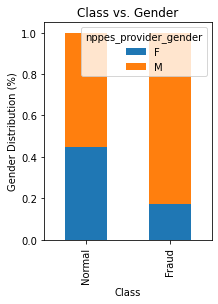

In [44]:
t=pd.crosstab(df2['exclude'], df2['nppes_provider_gender'])
t.div(t.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, figsize=(3, 4))
plt.title('Class vs. Gender')
plt.xlabel('Class')
plt.xticks([0,1],['Normal', 'Fraud'])
plt.ylabel('Gender Distribution (%)')
plt.show()

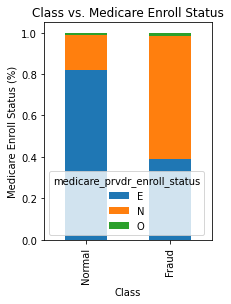

In [45]:
t=pd.crosstab(df2['exclude'], df2['medicare_prvdr_enroll_status'])
t.div(t.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, figsize=(3, 4))
plt.title('Class vs. Medicare Enroll Status')
plt.xlabel('Class')
plt.xticks([0,1],['Normal', 'Fraud'])
plt.ylabel('Medicare Enroll Status (%)')
plt.show()

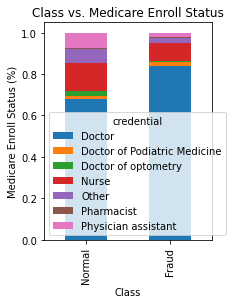

In [46]:
t=pd.crosstab(df2['exclude'], df2['credential'])
t.div(t.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, figsize=(3, 4))
plt.title('Class vs. Medicare Enroll Status')
plt.xlabel('Class')
plt.xticks([0,1],['Normal', 'Fraud'])
plt.ylabel('Medicare Enroll Status (%)')
plt.show()

Text(0.5, 1.0, 'Class vs. Total Claim Count')

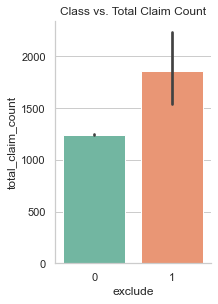

In [64]:
g = sns.catplot(data=df2, kind='bar', x='exclude', y='total_claim_count', palette='Set2', height=4, aspect=3/4)
plt.title('Class vs. Total Claim Count')

Text(0.5, 1.0, 'Class vs. Total 30 fill day count')

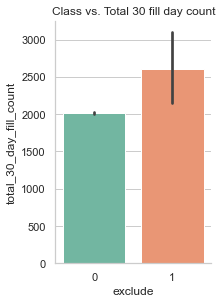

In [66]:
g = sns.catplot(data=df2, kind='bar', x='exclude', y='total_30_day_fill_count', palette='Set2', height=4, aspect=3/4)
plt.title('Class vs. Total 30 fill day count')

Text(0.5, 1.0, 'Class vs. Total day supply')

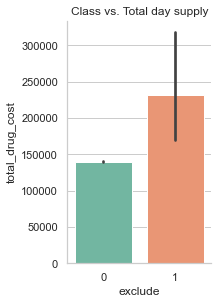

In [67]:
g = sns.catplot(data=df2, kind='bar', x='exclude', y='total_drug_cost', palette='Set2', height=4, aspect=3/4)
plt.title('Class vs. Total day supply')

Text(0.5, 1.0, 'Class vs. Total drug cost')

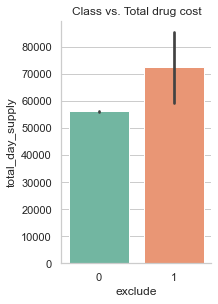

In [68]:
g = sns.catplot(data=df2, kind='bar', x='exclude', y='total_day_supply', palette='Set2', height=4, aspect=3/4)
plt.title('Class vs. Total drug cost')

Text(0.5, 1.0, 'Class vs. # of beneficiaries')

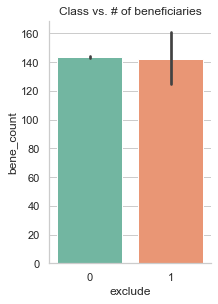

In [71]:
g = sns.catplot(data=df2, kind='bar', x='exclude', y='bene_count', palette='Set2', height=4, aspect=3/4)
plt.title('Class vs. # of beneficiaries')

Text(0.5, 1.0, 'Class vs. # of claims for age 65+')

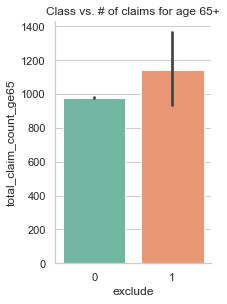

In [74]:
g = sns.catplot(data=df2, kind='bar', x='exclude', y='total_claim_count_ge65', palette='Set2', height=4, aspect=3/4)
plt.title('Class vs. # of claims for age 65+')

Text(0.5, 1.0, 'Class vs. # of claims for beneficiaries \ncovered by MAPD')

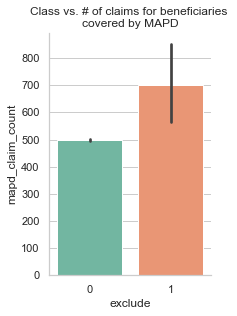

In [75]:
g = sns.catplot(data=df2, kind='bar', x='exclude', y='mapd_claim_count', palette='Set2', height=4, aspect=3/4)
plt.title('Class vs. # of claims for beneficiaries \ncovered by MAPD')

Text(0.5, 1.0, 'Class vs. # of claims for beneficiaries \ncovered by low-income subsidy')

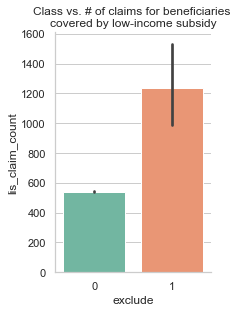

In [76]:
g = sns.catplot(data=df2, kind='bar', x='exclude', y='lis_claim_count', palette='Set2', height=4, aspect=3/4)
plt.title('Class vs. # of claims for beneficiaries \ncovered by low-income subsidy')

Text(0.5, 1.0, 'Class vs. # of claims of opioid drugs')

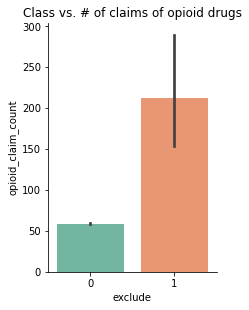

In [3]:
g = sns.catplot(data=df2, kind='bar', x='exclude', y='opioid_claim_count', palette='Set2', height=4, aspect=3/4)
plt.title('Class vs. # of claims of opioid drugs')

Text(0.5, 1.0, 'Class vs. # of claims of long-acting \nopioid drugs')

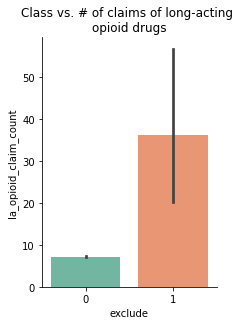

In [5]:
g = sns.catplot(data=df2, kind='bar', x='exclude', y='la_opioid_claim_count', palette='Set2', height=4, aspect=3/4)
plt.title('Class vs. # of claims of long-acting \nopioid drugs')

Text(0.5, 1.0, 'Class vs. Total Claims of Antibiotic Drugs')

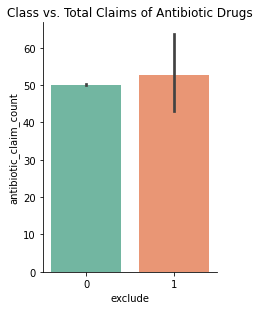

In [6]:
g = sns.catplot(data=df2, kind='bar', x='exclude', y='antibiotic_claim_count', palette='Set2', height=4, aspect=3/4)
plt.title('Class vs. Total Claims of Antibiotic Drugs')

Text(0.5, 1.0, 'Class vs. Total Claims of Antipsychotic Drugs \nfor Beneficiaries Age 65+')

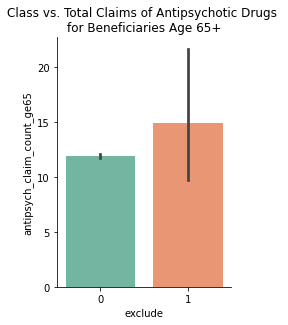

In [7]:
g = sns.catplot(data=df2, kind='bar', x='exclude', y='antipsych_claim_count_ge65', palette='Set2', height=4, aspect=3/4)
plt.title('Class vs. Total Claims of Antipsychotic Drugs \nfor Beneficiaries Age 65+')

## 2.3 One-hot encoding for categorical variables 

In [114]:
# Create dummies for categorical variables 
var_list = df2.columns.values.tolist()
#cat_vars = ['nppes_provider_gender','medicare_prvdr_enroll_status', 'credential']
cat_vars = ['nppes_provider_gender','credential']
for var in cat_vars:
    cat_list = 'var'+'_'+var
    cat_list = pd.get_dummies(df2[var], prefix=var, drop_first=True)
    df2 = df2.join(cat_list)
data_vars = df2.columns.values.tolist()
to_keep = [i for i in data_vars if i not in cat_vars]
df2 = df2[to_keep]

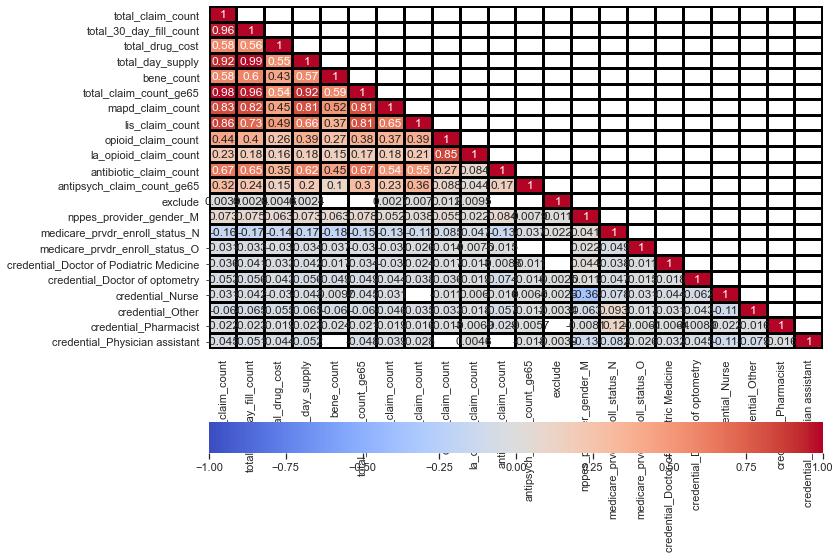

In [78]:
def plot_cor_matrix(corr, mask=None):
    f, ax = plt.subplots(figsize=(11, 9))
    sns.heatmap(corr, ax=ax,
                mask=mask,
                annot=True, vmin=-1, vmax=1, center=0,
                cmap='coolwarm', linewidths=2, linecolor='black', cbar_kws={'orientation': 'horizontal'})
    
# Plotting with significance filter
def corr_sig(df=None):
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            _ , p = stats.pearsonr(df[col],df[col2])
            p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
    return p_matrix

# seaborn will hide correlation were the boolean value is True in the mask
corr = df2.corr()                            # get correlation
p_values = corr_sig(df2)                     # get p-Value
mask = np.invert(np.tril(p_values<0.05))    # mask - only get significant corr
plot_cor_matrix(corr,mask)  

In [80]:
df2.to_csv('fraud.csv')

# 4. Modelling
* Algorithms chosen for the prediction 
    1. Logistic Regression and decision tree (baseline model): These models are chosen because they are frequently used in supervised classification problem. Also, as their fitting times are short, I used them as baseline models. 
    2. Random Forest: this model was chosen because the performance of decision tree was promising 
    3. Isolation Forest, One-class SVM (with undersampling), Autoencoder: These models were chosen because they are models specifically used in the field of anomaly detection. In anomaly detection, we learn the pattern of a normal process. Anything that does not follow this pattern is classified as an anomaly. 

In [2]:
df2 = pd.read_csv('fraud.csv')
df2 = df2.drop(columns='Unnamed: 0')

In [3]:
X = df2.drop('exclude',axis=1)
y = df2[['exclude']]

In [23]:
# Preprocessing for modelling 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#y_test = y_test.values
#y_train = y_train.values

# data standardization and oversampling
# Normalization across instances should be done after splitting the data between training and test set, using only the data from the training set.
std_scaler = StandardScaler()
std_scaler.fit(X_train)
X_train_scaled = std_scaler.transform(X_train)
X_test_scaled = std_scaler.transform(X_test)

# Split and then sampling. Try resampling ONLY the training set and not the test set Then train the model
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

## 4.1 Baseline models: Logistic Regression and Decision Tree

C:\Users\JK\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


              precision    recall  f1-score   support

           0       1.00      0.61      0.75    361354
           1       0.00      0.73      0.00       128

    accuracy                           0.61    361482
   macro avg       0.50      0.67      0.38    361482
weighted avg       1.00      0.61      0.75    361482

ROC_AUC 0.6699515485507287


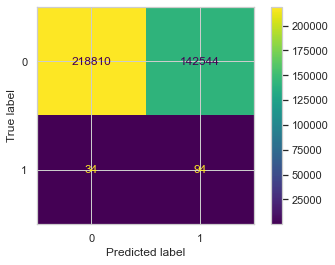

['lr.joblib']

In [117]:
# logistic regression 
lr = LogisticRegression()
lr.fit(X_train_smote, y_train_smote)
lr_y_pred = lr.predict(X_test_scaled)
print(classification_report(y_test, lr_y_pred))
print('ROC_AUC', roc_auc_score(y_test, lr_y_pred))
plot_confusion_matrix(lr, X_test_scaled, y_test)
plt.grid(False)
plt.show()  
dump(lr, 'lr.joblib')  # clf = load('filename.joblib')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    361354
           1       0.00      0.02      0.01       128

    accuracy                           1.00    361482
   macro avg       0.50      0.51      0.50    361482
weighted avg       1.00      1.00      1.00    361482

ROC_AUC 0.5106851375313405


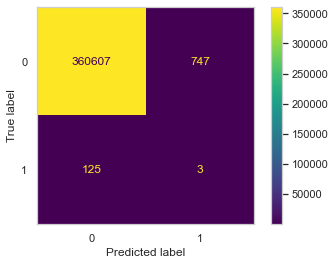

NameError: name 'dt_2' is not defined

In [118]:
# Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train_smote, y_train_smote)
dt_y_pred = dt.predict(X_test_scaled)
print(classification_report(y_test, dt_y_pred))
print('ROC_AUC', roc_auc_score(y_test, dt_y_pred))
plot_confusion_matrix(dt, X_test_scaled, y_test)
plt.grid(False)
plt.show() 
dump(dt, 'dt.joblib')  # clf = load('filename.joblib') 

## 4.2 Random Forest, Isolation Forest, One-class SVM

<ipython-input-124-b6155ebb4b7a>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train_smote, y_train_smote)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    361354
           1       0.05      0.03      0.04       128

    accuracy                           1.00    361482
   macro avg       0.52      0.52      0.52    361482
weighted avg       1.00      1.00      1.00    361482

ROC_AUC 0.515512921539543


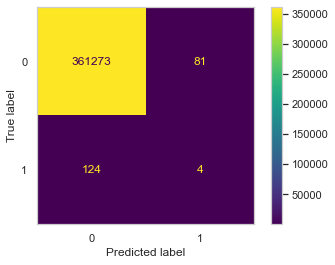

['rf_2.joblib']

In [124]:
# Random Forest 
rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train_smote, y_train_smote)
rf_y_pred = rf.predict(X_test_scaled)
print(classification_report(y_test, rf_y_pred))
print('ROC_AUC', roc_auc_score(y_test, rf_y_pred))
plot_confusion_matrix(rf, X_test_scaled, y_test)  
plt.grid(False)
plt.show() 
dump(rf, 'rf.joblib')  # clf = load('filename.joblib') 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    361354
           1       0.00      0.00      0.00       128

    accuracy                           1.00    361482
   macro avg       0.50      0.50      0.50    361482
weighted avg       1.00      1.00      1.00    361482

ROC_AUC 0.4998187373046929


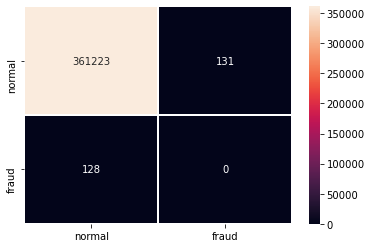

['isof.joblib']

In [112]:
# sklearn.ensemble.IsolationForest
isof = IsolationForest(n_estimators=100, contamination = 0.0004) # “contamination” argument, which is used to help define the number of outliers in the dataset.
isof.fit(pd.DataFrame(X_train)[y_train == 0]) # The model is probably best trained on examples that exclude outliers. 
isof_y_pred = isof.predict(X_test)
isof_y_pred[isof_y_pred == 1] = 0
isof_y_pred[isof_y_pred == -1] = 1

print(classification_report(y_test, isof_y_pred))
print('ROC_AUC', roc_auc_score(y_test, isof_y_pred))

Counter(isof_y_pred.tolist())
cm = confusion_matrix(y_test, isof_y_pred)
df_cm = pd.DataFrame(cm, index = ['normal', 'fraud'], columns = ['normal', 'fraud'])
sns.heatmap(df_cm, annot=True, cbar=True, fmt='d', linewidths=.5)
plt.grid(False)
plt.show()
dump(isof, 'isof.joblib') 

In [177]:
# Undersampling for One Class SVM
# Shuffle first
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
train_df = pd.concat([X_train,y_train], axis = 1)
train_df = train_df.sample(frac=1, random_state=42)

# For undersampling, check the number of fraudulent cases and the select the same number of normal cases 
len(train_df[train_df['exclude'] == 1]) # 320
train_fraud_us = train_df[train_df['exclude'] == 1]
train_normal_us = train_df[train_df['exclude'] == 0][:len(train_df[train_df['exclude'] == 1])]
train_df_us = pd.concat([train_fraud_us, train_normal_us])

X_train_us = train_df_us.drop('exclude',axis=1)
y_train_us = train_df_us[['exclude']]
X_train_us = X_train_us.values
y_train_us = y_train_us.values

std_scaler = StandardScaler()
std_scaler.fit(X_train_us)
X_train_us_scaled = std_scaler.transform(X_train_us)
X_test_us_scaled = std_scaler.transform(X_test)

              precision    recall  f1-score   support

           0       1.00      0.49      0.66    361354
           1       0.00      0.45      0.00       128

    accuracy                           0.49    361482
   macro avg       0.50      0.47      0.33    361482
weighted avg       1.00      0.49      0.66    361482

0.46798493046292555


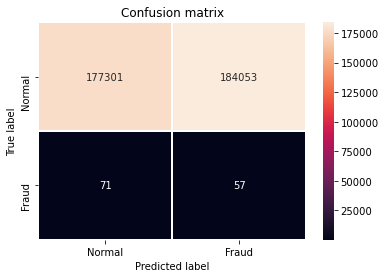

In [180]:
ocs = OneClassSVM(gamma='scale')
ocs.fit(X_train_us_scaled) # The model is probably best trained on examples that exclude outliers. 
ocs_y_pred = ocs.predict(X_test_us_scaled)
ocs_y_pred[ocs_y_pred == 1] = 0
ocs_y_pred[ocs_y_pred == -1] = 1
print(classification_report(y_test, ocs_y_pred))
print(roc_auc_score(y_test, ocs_y_pred))
ocs_cm = confusion_matrix(y_test, ocs_y_pred)
sns.heatmap(ocs_cm, xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'], annot=True, fmt="d", linewidths=.5);
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.grid(False)
plt.show()

## 4.3 Autoencoder

In [10]:
# Autoencoder 
# use only the normal data for training
X_train_normal = pd.DataFrame(X_train)[y_train == 0] 
y_train_normal = pd.DataFrame(y_train)[y_train == 0]

# min max scale the input data
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
X_train_normal_scaled = min_max_scaler.fit_transform(X_train_normal)
X_test_scaled = min_max_scaler.transform(X_test)

X_train_normal_scaled.dtype, X_test_scaled.dtype # (dtype('float64'), dtype('float64'))

In [25]:
# Make train, validation, and test set
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.3, random_state=42)

# Make sets only with normal cases + only with fraudulent cases 
X_train_normal = pd.DataFrame(X_train)[y_train['exclude'] == 0]
X_train_fraud = pd.DataFrame(X_train)[y_train['exclude'] == 1]
X_val_normal = pd.DataFrame(X_val)[y_val['exclude'] == 0]
X_val_fraud = pd.DataFrame(X_val)[y_val['exclude'] == 1]
X_test_normal = pd.DataFrame(X_test)[y_test['exclude'] == 0]
X_test_fraud = pd.DataFrame(X_test)[y_test['exclude'] == 1]

In [31]:
# Standardization 
scaler = StandardScaler().fit(X_train_normal)
X_train_normal_scaled = scaler.transform(X_train_normal)
X_val_normal_scaled = scaler.transform(X_val_normal)
X_val_scaled = scaler.transform(X_val) #? 
X_test_normal_scaled = scaler.transform(X_test_normal)
X_test_scaled = scaler.transform(X_test)

In [131]:
# Autoencoder Classification: initialization
batch_size = 128
input_dim = X_train_normal_scaled.shape[1] #num of predictor variables, 15 
encoding_dim = 128
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer) # 128
encoder = Dense(hidden_dim, activation="relu")(encoder) # 64
encoder = Dense(hidden_dim/2, activation="relu")(encoder) # 32
encoder = Dense(hidden_dim/4, activation="relu")(encoder) # 16
decoder = Dense(hidden_dim/4, activation="relu")(encoder)
decoder = Dense(hidden_dim/2, activation="relu")(decoder)
decoder = Dense(hidden_dim, activation="relu")(decoder)
decoder = Dense(encoding_dim, activation="relu")(decoder)
decoder = Dense(input_dim, activation="sigmoid")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
dense_32 (Dense)             (None, 128)               2048      
_________________________________________________________________
dense_33 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_34 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_35 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_36 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_37 (Dense)             (None, 32)                544 

In [132]:
# Autoencoder Classification: training
nb_epoch = 20
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='sgd')
cp = ModelCheckpoint(filepath="autoencoder_classifier.h5", save_best_only=True, verbose=0)
tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)
history = autoencoder.fit(X_train_normal_scaled, X_train_normal_scaled,epochs=nb_epoch, batch_size=batch_size,
                          shuffle=True, validation_data=(X_val_normal_scaled, X_val_normal_scaled), verbose=1, 
                          callbacks=[cp, tb]).history

Epoch 1/20
4611/4611 [==============================] - 8s 2ms/step - loss: 1.0579 - accuracy: 0.0707 - val_loss: 0.7490 - val_accuracy: 0.0798
Epoch 2/20
4611/4611 [==============================] - 7s 1ms/step - loss: 0.7863 - accuracy: 0.3091 - val_loss: 0.7388 - val_accuracy: 0.3370
Epoch 3/20
4611/4611 [==============================] - 7s 2ms/step - loss: 0.7936 - accuracy: 0.3405 - val_loss: 0.7197 - val_accuracy: 0.3513
Epoch 4/20
4611/4611 [==============================] - 8s 2ms/step - loss: 0.9102 - accuracy: 0.3628 - val_loss: 0.7164 - val_accuracy: 0.3915
Epoch 5/20
4611/4611 [==============================] - 8s 2ms/step - loss: 0.7656 - accuracy: 0.3996 - val_loss: 0.7135 - val_accuracy: 0.4080
Epoch 6/20
4611/4611 [==============================] - 9s 2ms/step - loss: 0.7736 - accuracy: 0.4093 - val_loss: 0.7109 - val_accuracy: 0.4057
Epoch 7/20
4611/4611 [==============================] - 8s 2ms/step - loss: 0.8135 - accuracy: 0.4050 - val_loss: 0.7086 - val_accuracy:

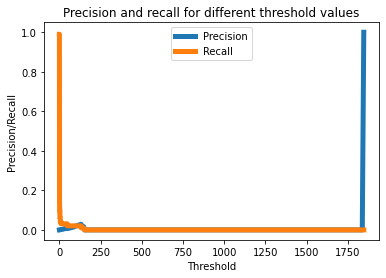

Threshold value: 132.1018419318579, index: 251876, f1 score: 0.02395209580838323


In [133]:
# Autoencoder Classification: find a threshold for the rare-event classification. Threshold should be decided based on validation data, as using the test data can result in overfitting.
X_val_pred = autoencoder.predict(X_val_scaled) # Feed the whole model
mse = np.mean(np.power(X_val_scaled - X_val_pred, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y_val['exclude']})
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

l_precision = precision_rt.tolist()
l_recall = recall_rt.tolist()
l_threshold = threshold_rt.tolist()
leng = len(l_threshold)
ae_prt = pd.DataFrame({'precision': l_precision[0:leng], 'recall': l_recall[0:leng], 'threshold': l_threshold})
ae_prt['f1'] = 2 * (ae_prt['precision'] * ae_prt['recall']) / (ae_prt['precision'] + ae_prt['recall'])
t_index = ae_prt['f1'].idxmax() # ae_prt.iloc[251226]
print('Threshold value: {0}, index: {1}, f1 score: {2}'.format(ae_prt.iloc[t_index]['threshold'], t_index, ae_prt.iloc[t_index]['f1']))

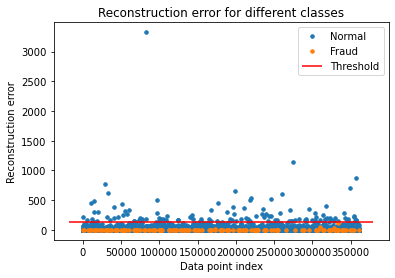

In [134]:
# Autoencoder Classification: predict X_test set 
threshold_fixed = 132 # from the graph
y_pred = autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(X_test_scaled - y_pred, 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y_test['exclude']})
error_df_test = error_df_test.reset_index()
groups = error_df_test.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='', label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();
# The orange and blue dots above the threshold line represents the True Positive and False Positive, respectively.

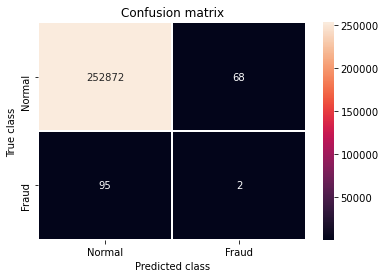

In [135]:
# Autoencoder Classification: confusion matrix
y_pred = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
ae_cm = confusion_matrix(error_df.True_class, y_pred)
sns.heatmap(ae_cm, xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'], annot=True, fmt="d", linewidths=.5);
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.grid(False)
plt.show()

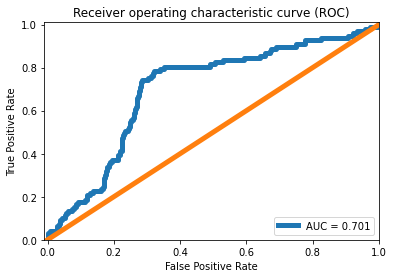

In [136]:
# Autoencoder Classification: AUC
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate)
plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [12]:
# Second Neural network model
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.3, random_state=42)
X_train = X_train.values
X_val = X_val.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values
y_val = y_val.values

# data standardization and oversampling
# Normalization across instances should be done after splitting the data between training and test set, using only the data from the training set.
std_scaler = StandardScaler()
std_scaler.fit(X_train)
X_train_scaled = std_scaler.transform(X_train)
X_val_scaled = std_scaler.transform(X_val)
X_test_scaled = std_scaler.transform(X_test)

# Split and then sampling. Try resampling ONLY the training set and not the test set Then train the model
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

In [16]:
nn = tf.keras.Sequential()
nn.add(Dense(100, input_dim=21, activation='relu'))
nn.add(Dense(100, activation='relu'))
nn.add(Dense(100, activation='relu'))
nn.add(Dense(1, activation='sigmoid'))
nn.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [17]:
nn_history = nn.fit(X_train_smote, y_train_smote, epochs=20, validation_data=(X_val_scaled, y_val))

Epoch 1/20
36888/36888 [==============================] - 43s 1ms/step - loss: 0.3382 - accuracy: 0.8419 - val_loss: 0.3206 - val_accuracy: 0.8128
Epoch 2/20
36888/36888 [==============================] - 43s 1ms/step - loss: 0.2497 - accuracy: 0.8838 - val_loss: 0.2028 - val_accuracy: 0.8960
Epoch 3/20
36888/36888 [==============================] - 42s 1ms/step - loss: 0.2208 - accuracy: 0.8968 - val_loss: 0.9335 - val_accuracy: 0.6228
Epoch 4/20
36888/36888 [==============================] - 42s 1ms/step - loss: 0.2012 - accuracy: 0.9064 - val_loss: 0.4208 - val_accuracy: 0.8522
Epoch 5/20
36888/36888 [==============================] - 42s 1ms/step - loss: 0.1861 - accuracy: 0.9144 - val_loss: 0.1492 - val_accuracy: 0.9246
Epoch 6/20
36888/36888 [==============================] - 42s 1ms/step - loss: 0.1735 - accuracy: 0.9211 - val_loss: 0.1692 - val_accuracy: 0.9074
Epoch 7/20
36888/36888 [==============================] - 42s 1ms/step - loss: 0.1636 - accuracy: 0.9264 - val_loss: 0

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


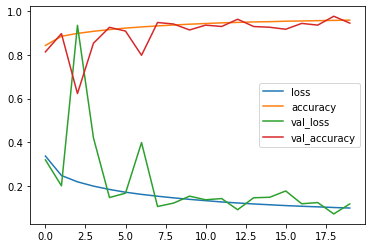

In [18]:
pd.DataFrame(nn_history.history).plot()
nn_y_pred = nn.predict_classes(X_test_scaled)

              precision    recall  f1-score   support

           0       1.00      0.94      0.97    361354
           1       0.00      0.23      0.00       128

    accuracy                           0.94    361482
   macro avg       0.50      0.59      0.49    361482
weighted avg       1.00      0.94      0.97    361482



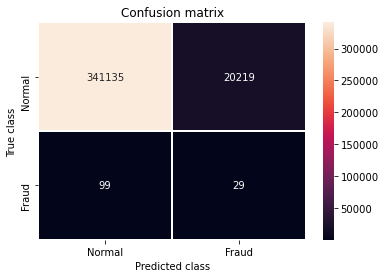

In [23]:
nn_cm = confusion_matrix(y_test, nn_y_pred)
print(classification_report(y_test, nn_y_pred))
sns.heatmap(nn_cm, xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'], annot=True, fmt="d", linewidths=.5);
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.grid(False)
plt.show()

## 4.4 Hyper parameter tuning
* Random Forest model has the highest precision (the chance of making false positives is low). 
* Note: due to processing difficulty, I did this part with a subset of data (50K entries)
* Unfortunately, the best model was worse than the initial model so discarded. The code for selecting the subset is accidently deleted. 

In [ ]:
# Preprocessing for modelling 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

# data standardization and oversampling
# Normalization across instances should be done after splitting the data between training and test set, using only the data from the training set.
std_scaler = StandardScaler()
std_scaler.fit(X_train)
X_train_scaled = std_scaler.transform(X_train)
X_test_scaled = std_scaler.transform(X_test)

# Split and then sampling. Try resampling ONLY the training set and not the test set Then train the model
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

In [90]:
# Parameter tuning for Random Forest Model
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [91]:
# Use the random search for best hyperparameters
rf = RandomForestClassifier(random_state = 42)
# Random search of parameters, using 3 fold cross validation
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 2, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_smote, y_train_smote)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


C:\Users\JK\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=2, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [92]:
rf_random.best_params_
best_random = rf_random.best_estimator_

In [94]:
best_random
dump(best_random, 'rf_best.joblib')  # clf = load('filename.joblib') 

['rf_best.joblib']

In [ ]:
# apply the model to the full data
df2 = pd.read_csv('fraud.csv')
df2 = df2.drop(columns='Unnamed: 0')
X = df2.drop('exclude',axis=1)
y = df2[['exclude']]

# Preprocessing for modelling 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#y_test = y_test.values
#y_train = y_train.values

# data standardization and oversampling
# Normalization across instances should be done after splitting the data between training and test set, using only the data from the training set.
std_scaler = StandardScaler()
std_scaler.fit(X_train)
X_train_scaled = std_scaler.transform(X_train)
X_test_scaled = std_scaler.transform(X_test)

# Split and then sampling. Try resampling ONLY the training set and not the test set Then train the model
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

              precision    recall  f1-score   support

           0       1.00      0.86      0.92    361354
           1       0.00      0.10      0.00       128

    accuracy                           0.86    361482
   macro avg       0.50      0.48      0.46    361482
weighted avg       1.00      0.86      0.92    361482

ROC_AUC 0.4807059222050953


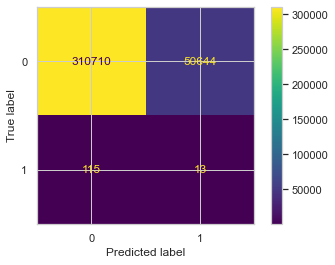

In [99]:
rf_best_y_pred = best_random.predict(X_test_scaled)
print(classification_report(y_test, rf_best_y_pred))
print('ROC_AUC', roc_auc_score(y_test, rf_best_y_pred))
plot_confusion_matrix(best_random, X_test_scaled, y_test)
plt.grid(False)
plt.show() 

# 5. Model Interpretation

<AxesSubplot:>

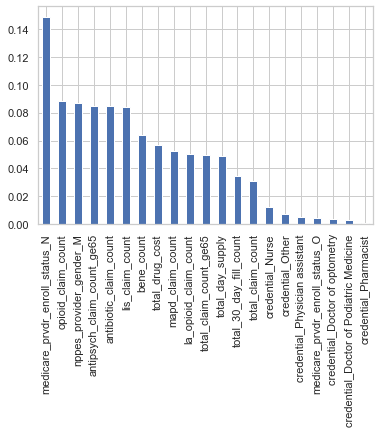

In [104]:
# Feature importance 
rf_imp = pd.Series(data = rf.feature_importances_, index = X.columns)
rf_imp.sort_values(ascending=False,inplace=True)
rf_imp.plot(kind='bar')

In [125]:
# Permutation importance 
perm = PermutationImportance(rf, random_state=1)
perm.fit(X_train_smote, y_train_smote)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [127]:
# Permutation importance weights 
eli5.show_weights(perm, feature_names=X.columns.tolist())

Weight,Feature
0.2079 ± 0.0003,lis_claim_count
0.2021 ± 0.0003,opioid_claim_count
0.1941 ± 0.0001,bene_count
0.1933 ± 0.0002,antipsych_claim_count_ge65
0.1902 ± 0.0004,antibiotic_claim_count
0.1806 ± 0.0002,total_drug_cost
0.1802 ± 0.0003,mapd_claim_count
0.1641 ± 0.0004,medicare_prvdr_enroll_status_N
0.1364 ± 0.0001,total_claim_count_ge65
0.1356 ± 0.0001,nppes_provider_gender_M


In [ ]:
# This part is incomplete because it took too much time to run the codes 
rf = load('rf.joblib') 
shap.initjs()
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

# 6. Conclusion
* Important features in the current model predicting fraudster: number of claims of opioid (positive relationship), # of claims of antibiotic drugs, # of claims of antipsychotic drugs for beneficiaries age 65+, medicare enrollment status (not enrolled), gender (men), number of claims  

* Future direction
    - Change the model: predict probability / change the evaluation metric if the goal is to detect true positives (even if the prediction includes false positives) 
    - Prescription / transaction level data
    - Other data: insurance fraud